## RFM으로 점수를 구하는 방법

In [67]:
import pandas as pd

df = pd.read_csv('./data/ecommerce-data.csv', encoding = 'ISO-8859-1')
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

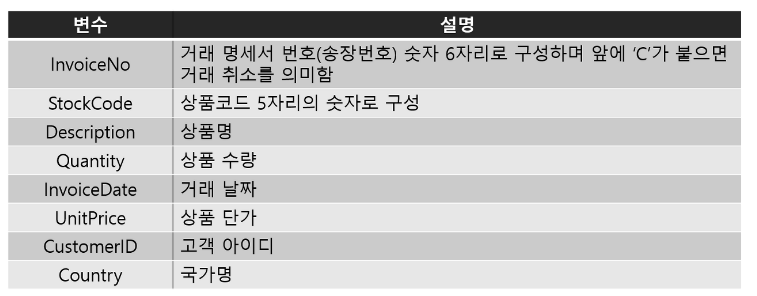

In [68]:
print(len(df))

541909


In [69]:
## 기간 보기
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) ## 문자열로된 날짜를 Timestamp형식으로 변환
 
set_of_year_month = list(set([(x.year, x.month) for x in df['InvoiceDate']])) ## 송장날짜에서 연도와 월정보를 가져온다.
for ym in sorted(set_of_year_month, key=lambda x: (x[0], x[1])): ## 연도와 월정보를 연도, 월 순으로 출력 
    print(f'{ym[0]}년 {ym[1]}월')

2010년 12월
2011년 1월
2011년 2월
2011년 3월
2011년 4월
2011년 5월
2011년 6월
2011년 7월
2011년 8월
2011년 9월
2011년 10월
2011년 11월
2011년 12월


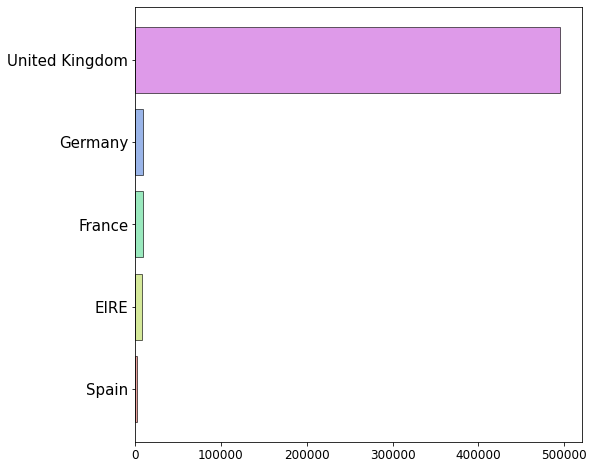

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
nation_data = Counter(df['Country']).most_common() #count함수
nation_data = nation_data[:5] #상위 5개만 저장


data = [x[1] for x in nation_data] #데이터 개수
nations = [x[0] for x in nation_data] ## 국가

#수평 바차트에서 데이터개수와 나라를 맨위로 출력하기 위해 리스트 순서를 바꿈
nations.reverse()
data.reverse()

#시각화
fig = plt.figure(figsize = (8,8))
fig.set_facecolor('white') #캔버스 색깔
colors = sns.color_palette('hls', len(data))
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 12)
plt.barh(nations, data, color = colors, alpha = 0.6, edgecolor= 'k')
plt.show()


## 데이터 전처리

In [71]:
import pandas as pd
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) ## 문자열로된 날짜를 Timestamp형식으로 변환


In [75]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [91]:
#분석할 나라와 연도 설정
target_country = 'United Kingdom'
target_year = '2011'

# @'변수명' and sql문으로 변수추출
df = df.query('Country == @target_country and InvoiceDate.dt.year == 2011')


#필요한 칼럼 추출
df = df[['InvoiceNo', 'Quantity', 'InvoiceDate','UnitPrice','CustomerID']]

# 결측값 처리
df = df.dropna()

# 구매 취소 데이터 삭제
# 송장번호 앞에 'C'가 있으면 삭제 구매 취소된 데이터를 의미한다. 여기서는 단순히 'C'가 있는지 없는지 보면된다 
df = df.query('InvoiceNo.str.get(0) != "C"')

## 데이터 분석하기 
- 고객별 
    - 방문일, 방문횟수 , 구매금액 기준으로 점수를 정리

In [95]:
# 데이터 분석
import pandas as pd
from tqdm import tqdm

customer_id = list(df['CustomerID'].unique())  #고객 아이디

# 먼저 각 고객별로 구매금액이 얼마인지 알아보자
monetary_df = pd.DataFrame()
monetary_df['CustomerID'] = customer_id #고객아이디 삽입
monetary_data = [] #구매 금액을 담을 리스트 
for ci in tqdm(customer_id, position = 0 , desc = 'Calculating amount of individual customer'):
    temp = df.query('CustomerID == @ci') #해당 아이디의 고객 추출
    amount = sum(temp['Quantity'] * temp['UnitPrice']) #해당 고객 구매 금액 (수량 x 가격)
    monetary_data.append(amount)

monetary_df['Monetary'] = monetary_data ## 구매금액 데이터 삽입

#Group by 나 applymap으로 푸는 방법 찾아 보기 아니면 판다스(곱하고 -> groun by)

# 각 고객별로 최근 방문일을 알아보자 
temp_recency_df = df[['CustomerID', "InvoiceDate"]].drop_duplicates() #고객 아이디와 송장 날짜만 추출 뒤 중복제거
recency_df = temp_recency_df.groupby('CustomerID')['InvoiceDate'].max().reset_index() #아이디로 그룹화 한 다음 최근 방문일을 구해야 하므로 송장 날짜에 max를 적용한다  max가 최근날짜
recency_df = recency_df.rename(columns = {'InvoiceDate': 'Recency'})

# 각 고객별 방문횟수를 알아보자 
temp_frequency_df = df[['CustomerID', 'InvoiceNo']].drop_duplicates()
frequency_df = temp_frequency_df.groupby('CustomerID')['InvoiceNo'].count().reset_index() # 이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 송장번호 개수로 생각했으므로 송장번호에 count를 적용
frequency_df = frequency_df.rename(columns = {'InvoiceNo': 'Frequency'})

#데이터를 고객아이듸를 기준으로 합쳐야 한다 
rfm_df = pd.merge(recency_df,frequency_df,how='left',on='CustomerID')
rfm_df = pd.merge(rfm_df,monetary_df,how='left',on='CustomerID')  

Calculating amount of individual customer: 100%|██████████████████████████████████| 3814/3814 [00:14<00:00, 264.70it/s]


In [96]:
rfm_df

,CustomerID,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:01:00,1,77183.60
1,12747.0,2011-12-07 14:34:00,9,3489.74
2,12748.0,2011-12-09 12:20:00,175,29491.60
3,12749.0,2011-12-06 09:56:00,5,4090.88
4,12820.0,2011-12-06 15:12:00,4,942.34
...,...,...,...,...
3809,18280.0,2011-03-07 09:52:00,1,180.60
3810,18281.0,2011-06-12 10:53:00,1,80.82
3811,18282.0,2011-12-02 11:43:00,2,178.05
3812,18283.0,2011-12-06 12:02:00,16,2094.88


## 날짜의 기준 시간잡기 
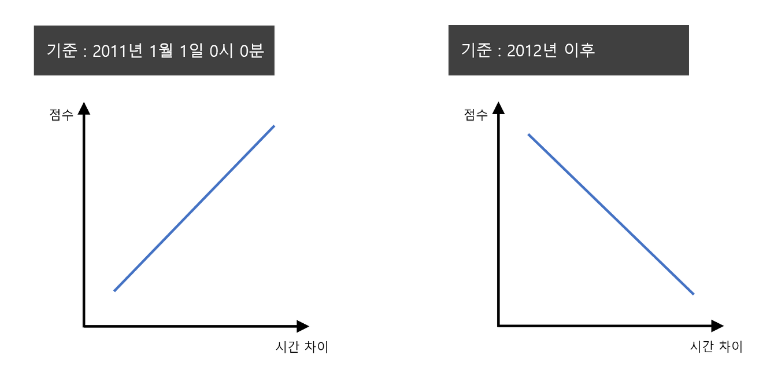
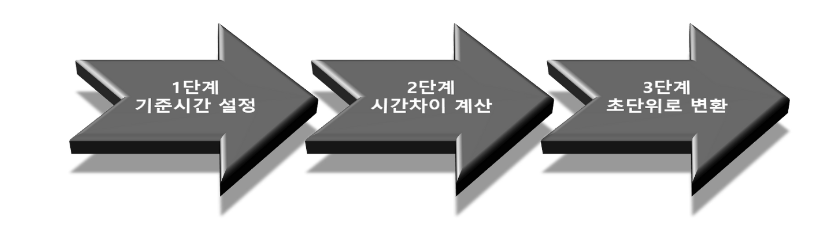

In [97]:
# 데이터 변환
current_day = pd.to_datetime('20110101')
time_diff = rfm_df['Recency']-current_day  #최근 방문일과 기준날짜의 시간차이 
time_in_seconds = [x.total_seconds() for x in time_diff] #시간 차이를 초단위로 계산
rfm_df['Recency'] = time_in_seconds #변환데이터를 삽입

In [98]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,1504860.0,1,77183.60
1,12747.0,29428440.0,9,3489.74
2,12748.0,29593200.0,175,29491.60
3,12749.0,29325360.0,5,4090.88
4,12820.0,29344320.0,4,942.34


In [111]:
# get_score 와 get_rfm_grade 함수 이용

def get_score(level, data):
    '''
    Description :
    level안에 있는 원소를 기준으로 1 - len(level) + 1 까지 점수를 부여하는 함수 
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함
    예 - [1,2,3,4,5] 0, [5,4,3,2,1] X, [1,3,2,10,4] X
    data = 점수를 부여할 데이터, 순회가능한(iterable) 데이터 형식
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = []
    for j in range(len(data)):
        for i in range(len(level)):
            if data[j] <= level[i]:
                score.append(i + 1)
                break
            elif data[j] > max(level):
                score.append(len(level) + 1)
                break
            else:
                continue
    return score

def get_rfm_grade(df, num_class, rfm_tick_point, rfm_col_map, suffix=None):
    '''
    Description :
    개별 고객에 대한 최근방문일/방문횟수/구매금액 데이터가 주어졌을때
    최근방문일/방문횟수/구매금액 점수를 계산하여 주어진 데이터 오른쪽에 붙여줍니다.
    
    Parameters :
    df = pandas.DataFrame 데이터
    num_class = 등급(점수) 개수
    rfm_tick_point = 최근방문일/방문횟수/구매금액에 대해서 등급을 나눌 기준이 되는 값
                    'quantile', 'min_max' 또는 리스트를 통하여 직접 값을 정할 수 있음.
                    단, 리스트 사용시 원소의 개수는 반드시 num_class - 1 이어야함.
                    quatile = 데이터의 분위수를 기준으로 점수를 매김
                    min_max = 데이터의 최소값과 최대값을 동일 간격으로 나누어 점수를 매김
    rfm_col_map = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명
    예 - {'R':'Recency','F':'Frequency','M':'Monetary'}
    suffix = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명 뒤에 붙는 접미사
    Return : 
    pandas.DataFrame
    '''
    ##### 필요모듈 체크
    import pandas as pd
    import numpy as np
    from sklearn import preprocessing
    
    ##### 파라미터 체크 (에러처리 )
    if not isinstance(df, pd.DataFrame): ## 데이터는 pd.DataFrame이어야 함.
        print('데이터는 pandas.DataFrame 객체여야 합니다.')
        return
    
    if isinstance(rfm_tick_point, dict) == False or isinstance(rfm_col_map, dict) == False: ## rfm_tick_point와 rfm_col_map은 모두 딕셔너리
        print(f'rfm_tick_point와 rfm_col_map은 모두 딕셔너리여야합니다.')
        return
    
    if len(rfm_col_map) != 3: ## rfm_col_map에는 반드시 3개의 키를 가져아함.
        print(f'rfm_col_map인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if len(rfm_tick_point) != 3: ## rfm_tick_point에는 반드시 3개의 키를 가져아함.
        print(f'rfm_tick_point인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if set(rfm_tick_point.keys()) != set(rfm_col_map.keys()): ## rfm_tick_point와 rfm_col_map은 같은 키를 가져야함.
        print(f'rfm_tick_point와 rfm_col_map은 같은 키를 가져야 합니다.')
        return
    
    if not set(rfm_col_map.values()).issubset(set(df.columns)):
        not_in_df = set(rfm_col_map.values())-set(df.columns)
        print(f'{not_in_df}이 데이터 칼럼에 있어야 합니다.')
        return
    
    for k, v in rfm_tick_point.items():
        if isinstance(v, str):
            if not v in ['quantile','min_max']:
                print(f'{k}의 값은 "quantile" 또는 "min_max"중에 하나여야 합니다.')
                return
        elif isinstance(v,list) or isinstance(v,tuple):
            if len(v) != num_class-1:
                print(f'{k}에 대응하는 리스트(튜플)의 원소는 {num_class-1}개여야 합니다.')
                return
    
    if suffix:
        if not isinstance(suffix, str):
            print('suffix인자는 문자열이어야합니다.')
            return
        
    ##### 최근방문일/방문횟수/구매금액 점수 부여
    for k, v in rfm_tick_point.items():
        # 문자값이 들어오는 경우 
        if isinstance(v,str):
            if v == 'quantile':
                ## 데이터 변환
                scale = preprocessing.StandardScaler() ## 데이터의 범위 조작하기 쉽게 해주는 클래스 
                temp_data = np.array(df[rfm_col_map[k]]) ## 데이터를 Numpy 배열로 변환
                temp_data = temp_data.reshape((-1,1)) ## scale을 적용하기위해 1차원 배열을 2차원으로 변환
                temp_data = scale.fit_transform(temp_data) ## 데이터를 평균은 0, 표준편차는 1을 갖도록 변환  표준화
                temp_data = temp_data.squeeze() ## 데이터를 다시 1차원으로 변환
                ## 분위수 벡터
                quantiles_level = np.linspace(0,1,num_class+1)[1:-1] ## 분위수를 구할 기준값을 지정 0과 1은 제외
                quantiles = [] ## 분위수를 담을 리스트
                for ql in quantiles_level:
                    quantiles.append(np.quantile(temp_data,ql)) ## 분위수를 계산하고 리스트에 삽입
            else: ## min_max인 경우
                ## 데이터 변환
                temp_data = np.array(df[rfm_col_map[k]])
                ## 등분점 계산
                quantiles = np.linspace(np.min(temp_data),np.max(temp_data),num_class+1)[1:-1] ## 최소값과 최대값을 점수 개수만큼 등간격으로 분할하는 점
        else: ## 직접 구분값을 넣어주는 경우
            temp_data = np.array(df[rfm_col_map[k]])
            quantiles = v ## 직접 구분값을 넣어줌
        score = get_score(quantiles, temp_data) ## 구분값을 기준으로 점수를 부여하고 리스트로 저장한다.
        new_col_name = rfm_col_map[k]+'_'+k ## 점수값을 담는 변수의 이름
        if suffix:
            new_col_name = rfm_col_map[k]+'_'+suffix
        df[new_col_name] = score ## 기존데이터 옆에 점수 데이터를 추가한다.
    return df

In [112]:
#예시
get_score([55,85],[100, 85, 70, 60, 55])

[3, 2, 2, 2, 1]

## 분위수를 이용하기
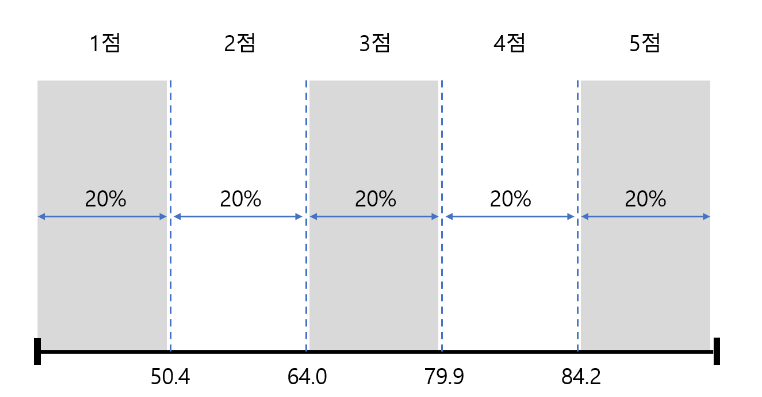

In [113]:
# 분위수 구하는 방법
import numpy as np

# 0 ~ 1 퍼센트로 
data = [30, 40, 53, 55, 70, 79, 81, 83, 89, 95]
for x in np.linspace(0,1,6)[1:-1]:
    print(f'분위수: {np.quantile(data,x):.1f}')

분위수: 50.4
분위수: 64.0
분위수: 79.8
분위수: 84.2


## 최소값과 촤디값을 이용하는 방법
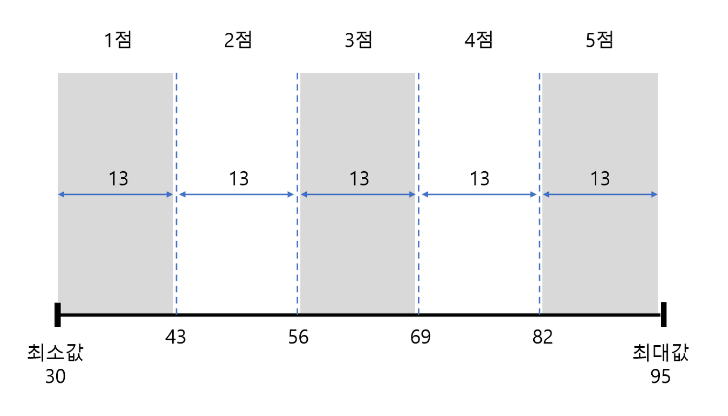

In [116]:
import numpy as np
 
# 최소 최대 ~구간
data = [30, 40, 53, 55, 70, 79, 81, 83, 89, 95]
for x in np.linspace(np.min(data),np.max(data),6)[1:-1]:
    print(f'구분값 : {x:.1f}')

구분값 : 43.0
구분값 : 56.0
구분값 : 69.0
구분값 : 82.0


## 직접 기준값을 정하는 방법
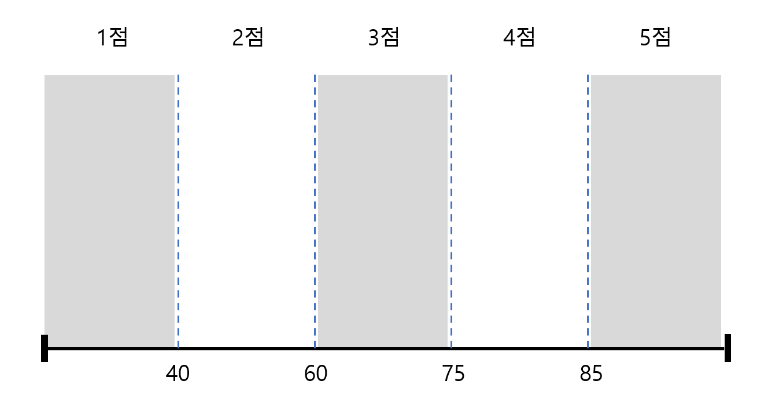

- 데이터에 압도적으로 크거나 작은 값이 있다면 분위수 (이상치가 크다면)
- 값의 크기가 중요하다고 판단되는 경우 최소값, 최대값을 이용하는 방법


In [120]:
rfm_tick_point={'R':'quantile','F':'quantile','M':'quantile'}
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}
 
#분위수로 점수를 구하는 함수를 이용
result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result.to_csv('result.csv',index=False)

result.head()

,CustomerID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M
0,12346.0,1504860.0,1,77183.60,1,1,5
1,12747.0,29428440.0,9,3489.74,5,5,5
2,12748.0,29593200.0,175,29491.60,5,5,5
3,12749.0,29325360.0,5,4090.88,5,4,5
4,12820.0,29344320.0,4,942.34,5,4,4


In [121]:
#최소값과 최대값을 이용하는 방법
rfm_tick_point={'R':'quantile','F':'quantile','M':'min_max'} ## 구매금액에 최소값 최대값을 이용한 방법 적용
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}
 
result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result[['CustomerID','Recency_R','Frequency_F','Monetary_M']]
result.head()

,CustomerID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M
0,12346.0,1504860.0,1,77183.60,1,1,2
1,12747.0,29428440.0,9,3489.74,5,5,1
2,12748.0,29593200.0,175,29491.60,5,5,1
3,12749.0,29325360.0,5,4090.88,5,4,1
4,12820.0,29344320.0,4,942.34,5,4,1


In [122]:
#직접 기준값을 정하는 방법
rfm_tick_point={'R':'quantile','F':[5, 10, 50, 90],'M':'quantile'} ## 방문 횟수에 직접 기준값을 정하는 방법 적용
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}
 
result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result[['CustomerID','Recency_R','Frequency_F','Monetary_M']]
result.head()

,CustomerID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M
0,12346.0,1504860.0,1,77183.60,1,1,5
1,12747.0,29428440.0,9,3489.74,5,2,5
2,12748.0,29593200.0,175,29491.60,5,5,5
3,12749.0,29325360.0,5,4090.88,5,1,5
4,12820.0,29344320.0,4,942.34,5,1,4


## RFM 가중치 계산 

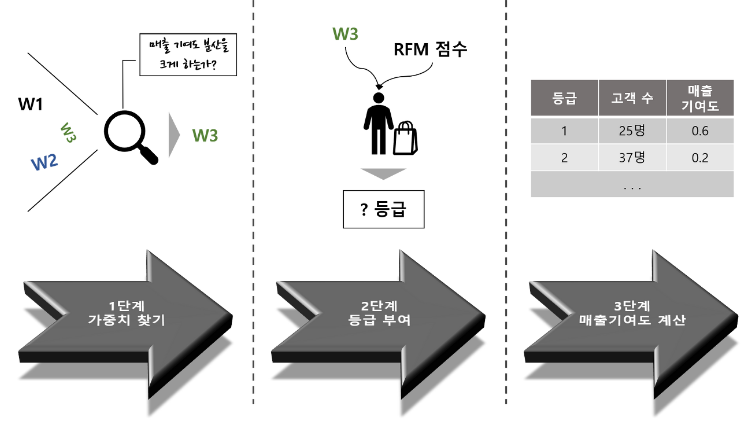

In [1]:
import pandas as pd
rfm_score = pd.read_csv('result.csv')
rfm_score.head()

,CustomerID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M
0,12346.0,1504860.0,1,77183.60,1,1,5
1,12747.0,29428440.0,9,3489.74,5,5,5
2,12748.0,29593200.0,175,29491.60,5,5,5
3,12749.0,29325360.0,5,4090.88,5,4,5
4,12820.0,29344320.0,4,942.34,5,4,4


In [2]:
## 필요 변수 추출
rfm_score = rfm_score[['CustomerID', 'Monetary', 'Recency_R','Frequency_F','Monetary_M']]
rfm_score.head()

,CustomerID,Monetary,Recency_R,Frequency_F,Monetary_M
0,12346.0,77183.60,1,1,5
1,12747.0,3489.74,5,5,5
2,12748.0,29491.60,5,5,5
3,12749.0,4090.88,5,4,5
4,12820.0,942.34,5,4,4


## 매출 기여도의 분산을 최대화하는 가중치 찾기 
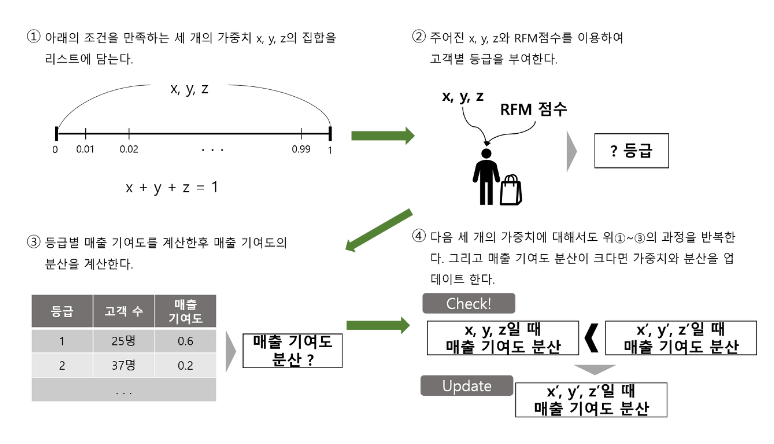

In [3]:
import pandas as pd
import numpy as np 
from tqdm import tqdm


#최적 가중치를 찾기 위한 함수 및 사전 준비 코드 
def get_score(level, data, reverse = False):
    '''
    Description :
    level안에 있는 원소를 기준으로
    1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
    예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
    data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
    reverse = 점수가 높을 때 그에 해당하는 값을 낮게 설정하고 싶을 때 True
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = [] 
    for j in range(len(data)): 
        for i in range(len(level)): 
            if data[j] <= level[i]: 
                score.append(i+1) 
                break 
            elif data[j] > max(level): 
                score.append(len(level)+1) 
                break 
            else: 
                continue
    if reverse:
        return [len(level)+2-x for x in score] #점수가 높을수록 등급이 낮게하는 설정
    else:
        return score 
 
# 최근 구매일, 방문횟수 , 구매금액에 부여할 가중치를 0부터 1까지 0.01단위로 분할

grid_number = 100 ## 눈금 개수, 너무 크게 잡으면 메모리 문제가 발생할 수 있음.
weights = []
for j in range(grid_number+1):
    weights += [(i/grid_number,j/grid_number,(grid_number-i-j)/grid_number)
                  for i in range(grid_number+1-j)]

# 등급의 개수를 정함
num_class = 5 ## 클래스 개수
class_level = np.linspace(1,5,num_class+1)[1:-1] ## 클래스를 나누는 지점을 정한다.
total_amount_of_sales = rfm_score['Monetary'].sum() ## 구매금액 총합 = 총 매출


In [7]:
# 최적 가중치를 찾는 코드 
max_std = 0  #표준편차 초기값
for w in tqdm(weights, position = 0 , desc = "[Finding Optimal weights]"):
    # 주어진 가중치에 따른 고객별 점수 계산
    score = w[0] * rfm_score['Recency_R'] + w[1] * rfm_score['Frequency_F'] + w[2] * rfm_score['Monetary_M']
    rfm_score['Class'] = get_score(class_level, score, True) #점수를 이용하여 고객별 등급 부여
    grouped_rfm_score = rfm_score.groupby('Class')['Monetary'].sum().reset_index()
    
    #클래스별 구매 금액을 총 구매금액으로 나누어 클래스별 매출 기여도 계산
    grouped_rfm_score['Monetary'] = grouped_rfm_score['Monetary'].map(lambda x: x/total_amount_of_sales)
    std_sales = grouped_rfm_score['Monetary'].std() #매출 기여도의 표준편차 계산
    #max_std 는 0으로 시작 
    if max_std <= std_sales:
        max_std = std_sales #표준편차 최대값 업데이트
        optimal_weights = w #가중치 없데이트

#최대 분산을 찾는 문제를 최대 표준편차를 찾는 문제로 바꿈 (표준편차는 음이 아닌 값이고 표준편차가 커질수록 분산도 커지므로 최대 분산을 찾는 문제와 최대 표준편차를 찾는 문제가 같아 지기 때문에)
        
        
    

[Finding Optimal weights]: 100%|███████████████████████████████████████████████████| 5151/5151 [03:25<00:00, 25.07it/s]


In [14]:
print(optimal_weights) #최대 표준편차로 최적 가중치를 보여준다 


(0.0, 0.26, 0.74)


## 가중치와 RFM점수를 이용하여 고객별로 등급 부여

In [9]:
score = optimal_weights[0] * rfm_score['Recency_R'] + optimal_weights[1] * rfm_score['Frequency_F'] + optimal_weights[2] * rfm_score['Monetary_M']

rfm_score['Class'] = get_score(class_level, score,True) #고객별 등급 부여 


## 각 등급별 매출 기여도 확인


In [17]:
# 클래스별 고객 수 계산
temp_rfm_score1 = rfm_score.groupby('Class')['CustomerID'].count().reset_index()

# 클래스별 구매금액(매출) 계산 
temp_rfm_score2 = rfm_score.groupby('Class')['Monetary'].sum().reset_index()

# 클래스별 매출 기여도 계산
temp_rfm_score2['Monetary'] = temp_rfm_score2['Monetary'].map(lambda x: x/total_amount_of_sales)

# 데이터 결함
result_df = pd.merge(temp_rfm_score1, temp_rfm_score2, how = 'left', on = ('Class') )



In [18]:
result_df

,Class,CustomerID,Monetary
0,1,901,0.744452
1,2,587,0.121736
2,3,618,0.063758
3,4,483,0.031131
4,5,1225,0.038923


## 등급이 높을수록 매출 기여도가 높아야 한다는 제약조건을 추가

In [22]:
max_std = 0
for w in tqdm(weights, position = 0 , desc = '[Finding Optimal weights]'):
    # 주어진 가중치에 따른 고객별 점수 계산
    score = w[0] * rfm_score['Recency_R'] + w[1] * rfm_score['Frequency_F'] + w[2] * rfm_score['Monetary_M']
    rfm_score['Class'] = get_score(class_level, score, True) #점수를 이용하여 고객별 등급 부여
    #등급별로 구매금액을 집계
    grouped_rfm_score = rfm_score.groupby('Class')['Monetary'].sum().reset_index()
    # 제약 조건 추가 - 등급이 높은 고객들의 매출이 낮은 등급의 고객들 보다 커야한다 
    grouped_rfm_score = grouped_rfm_score.sort_values('Class')
    temp_monetary = list(grouped_rfm_score['Monetary'])
    if temp_monetary != sorted(temp_monetary, reverse =True):
        continue
    
    #클래스별 구매 금액을 총 구매금액으로 나누어 클래스별 매출 기여도 계산
    grouped_rfm_score['Monetary'] = grouped_rfm_score['Monetary'].map(lambda x: x/total_amount_of_sales)
    std_sales = grouped_rfm_score['Monetary'].std() #매출 기여도의 표준편차 계산
    #max_std 는 0으로 시작 
    if max_std <= std_sales:
        max_std = std_sales #표준편차 최대값 업데이트
        optimal_weights = w #가중치 없데이트

[Finding Optimal weights]: 100%|███████████████████████████████████████████████████| 5151/5151 [03:24<00:00, 25.15it/s]


In [23]:
print(optimal_weights)

(0.02, 0.23, 0.75)


In [27]:
score = optimal_weights[0] * rfm_score['Recency_R'] + optimal_weights[1] * rfm_score['Frequency_F'] + optimal_weights[2] * rfm_score['Monetary_M']

rfm_score['Class'] = get_score(class_level, score,True) #고객별 등급 부여 


# 클래스별 고객 수 계산
temp_rfm_score1 = rfm_score.groupby('Class')['CustomerID'].count().reset_index()

# 클래스별 구매금액(매출) 계산 
temp_rfm_score2 = rfm_score.groupby('Class')['Monetary'].sum().reset_index()

# 클래스별 매출 기여도 계산
temp_rfm_score2['Monetary'] = temp_rfm_score2['Monetary'].map(lambda x: x/total_amount_of_sales)

# 데이터 결함
result_df = pd.merge(temp_rfm_score1, temp_rfm_score2, how = 'left', on = ('Class') )

result_df

,Class,CustomerID,Monetary
0,1,886,0.741459
1,2,602,0.124730
2,3,618,0.063758
3,4,563,0.035032
4,5,1145,0.035022


## 결과 해석
- A고객 : 최근 구매일, 방문 횟수, 구매금액 -> 3, 4, 5 이면 ==> 3 * 0.02 + 4 * 0.23, 5 * 0.75 = 0.06 + 0.92 + 3.75 =4.73 이므로 4등급 고객이 되는 것이다 
- 1등급 고객이 매출의 74% 